In [1]:
!pip install typeguard
!pip install awswrangler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 9.9 MB/s eta 0:00:00ta 0:00:01


In [2]:
import os
import pandas as pd
import boto3
from datetime import datetime, timedelta

import importlib
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, FloatSlider
import order_book.transformation
from order_book.simulation import *
from order_book.transformation import *
from order_book.loader import *
import awswrangler as wr

from tensorflow.keras.callbacks import Callback
import ml_model
from ml_model.test_model import *

from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

2024-05-28 08:10:22.178100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 08:10:22.178216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 08:10:23.922796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 08:10:26.946771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 08:10:35.551805: W tensorflow/comp

In [3]:
importlib.reload(order_book.transformation)
from order_book.transformation import *

importlib.reload(ml_model.test_model)
from ml_model.test_model import *

In [4]:
dl = DataLoader()

In [10]:
for i in range(1,32,1):
    start = datetime(2024, 1, i, 20)
    end = datetime(2024, 1, i, 21)

    order_data = dl.get_raw_product_orders(start, end)

In [6]:
start = datetime(2024, 1, 5, 20)
end = datetime(2024, 1, 5, 21)

order_data = dl.get_raw_product_orders(start, end)

In [10]:
num_orders = 5
num_obs = 5
horizons = 4
ticks = 1000

### Visualization

In [11]:
ob_series = to_ob_series_by_ticks(order_data, num_orders=num_orders, ticks=ticks)

In [12]:
price_trends = get_price_trends(ob_series, horizons=horizons)

In [13]:
ob_vectors, change_vectors = ob_series_to_vectors(ob_series)

In [20]:
x_data, y_data = vecs_to_model_input(change_vectors, num_obs, price_trends, horizons)

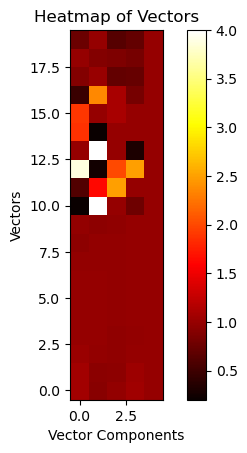

In [15]:
plt.imshow(x_data[2].T, cmap='hot', interpolation='nearest', origin='lower', vmax=4)

# Adding color bar to show the scale
plt.colorbar()

# Adding labels
plt.xlabel('Vector Components')
plt.ylabel('Vectors')
plt.title('Heatmap of Vectors')

# Display the heatmap
plt.show()

### Training

In [16]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
len(x_data)

117

In [25]:
model = get_model(num_obs = num_obs, num_orders=num_orders, horizons=horizons)

optimizer = Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

epochs = 10
split_train_val = 100


x_train = x_data[:100]
y_train = y_data[:100]


model.fit(
    x_train, y_train,
    epochs=epochs, verbose=1,
)

Epoch 1/10


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 12s 3s/step - loss: 3.0503 - accuracy: 0.3550
Epoch 2/10
4/4 [==============================] - 11s 3s/step - loss: 1.3046 - accuracy: 0.4025
Epoch 3/10
4/4 [==============================] - 11s 3s/step - loss: 0.9230 - accuracy: 0.5025
Epoch 4/10
4/4 [==============================] - 11s 3s/step - loss: 0.7708 - accuracy: 0.6325
Epoch 5/10
4/4 [==============================] - 11s 3s/step - loss: 0.6710 - accuracy: 0.7125
Epoch 6/10
4/4 [==============================] - 11s 3s/step - loss: 0.5757 - accuracy: 0.7750
Epoch 7/10
4/4 [==============================] - 11s 3s/step - loss: 0.4514 - accuracy: 0.9000
Epoch 8/10
4/4 [==============================] - 11s 3s/step - loss: 0.3754 - accuracy: 0.9150
Epoch 9/10
4/4 [==============================] - 10s 3s/step - loss: 0.2806 - accuracy: 0.9225
Epoch 10/10
4/4 [==============================] - 11s 3s/step - loss: 0.1954 - accuracy: 0.9650


In [29]:
model.predict(np.array([x_data[100]]))

1/1 [==============================] - 0s 91ms/step


array([[[2.7403174e-02, 9.6297181e-01, 9.6250167e-03],
        [5.9188559e-04, 5.4349816e-01, 4.5590997e-01],
        [1.9316598e-03, 2.1573377e-01, 7.8233463e-01],
        [1.9936305e-01, 2.7066082e-02, 7.7357090e-01]]], dtype=float32)

In [28]:
y_data[100]

array([[0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])